# Neural Network Model: Build, Train, Predict

The following notebook uses different feature sets to train a neural network. Along with using different feature sets, neural net parameters are changed and optimized to try to increase the accuracy. Once the optimum model is found, it is used to make predictions on the test_set data. Finally, the predictions are plotted to understand their distribution compared to the initial training data.

## Preliminaries

### Import Libraries

In [1]:
# data/math manipulation
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns instead of truncated list when using head/tail function
import numpy as np
import math
from numpy import errstate, isneginf

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# garbage collection
import gc

# file paths/saving
from pathlib import Path
import pickle
import h5py

# sklearn libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# nueral network libraries
import keras
from keras.models import Sequential, Input, Model, load_model
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils, to_categorical

import time
import warnings
import itertools

Using TensorFlow backend.


### Import Training Data

In [2]:
# create folder path where data lives
data_folder = Path('C:/Users/Kathleen Lange/MSDS692_Practicum_I')

In [3]:
# load feature sets from pickle files
feat_set1 = pd.read_pickle(data_folder / 'all_manual_features.pk')
feat_set1_scaled = pd.read_pickle(data_folder / 'all_manual_features_scaled.pk')
feat_set5_scaled = pd.read_pickle(data_folder / 'auto_FT_ss.pk')

# Feature sets 1, 2, 2scaled, 3, 4, and 5 all showed far worse performance after the first 
# few iterations of the neural network architecture than the above two feature sets. 
# I focus the rest of this notebook on optimizing the top two feature sets.

In [4]:
# for use in the k-folds and confusion matrix plotting
y1_target_list = feat_set1_scaled['target'] # list of only the targets, not ohc
class_names = list(np.unique(y1_target_list)) # unique class names, number of targets

### Prepare Data for Model Input

The target variable needs to be separated from the rest of the features in the dataframe so the features can be fed to the neural net for training. Also, the target variable is a multi-class object and needs to be converted to be one-hot encoded for the nueral network to work correctly. 

In [5]:
def prep_data_for_NN(df):
    y_train = df['target'].astype('category')
    y_train = y_train.cat.codes
    y_train_OHC = to_categorical(y_train) # one-hot encoding y-values
    
    X_train = df.drop(columns=['target'])
    
    return X_train, y_train_OHC

In [6]:
X1_scaled_train, y1_scaled_train = prep_data_for_NN(feat_set1_scaled)
X5_scaled_train, y5_scaled_train = prep_data_for_NN(feat_set5_scaled)

The non-scaled version of the first feature set is also loaded for future use with the testing data set. I use these data points to fit the StandardScalar function to so that as the chunks are read in during the testing set predictions process, then those values can be transformed using the previously determined fit. This is to ensure that all of the values in the testing set are transformed in the same manner.

In [7]:
X1_train, y1_train = prep_data_for_NN(feat_set1)
X1_train.reset_index(inplace=True)
X1_train.drop(columns=['origin'], inplace=True)

## Build Model

Initial build of Keras deep learning neural net followed from [this blog post](https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37). The steps in building the model are described below:  
- Using a sequential model allows you to build up the model layer by layer. 
- The number of columns/features is the shape of the input layer.
- The number of unique targets becomes the number of classes that can be predicted. This value becomes the number of neurons/nodes of the output layer.
- The number of nodes for each of the hidden layers is an important parameter to set. If there are too few nodes, then the model can result in underfitting. If there are too many nodes, then the model will take longer to train and can result in overfitting. This [blog post from Heaton Research](https://www.heatonresearch.com/2017/06/01/hidden-layers.html) suggests a couple of rule of thumbs for choosing the number of hidden layer nodes. For this project I have used the following formula:
    - (2/3)(number input features) + (number classes)
- Each layer is added to the model using the add() function. As a rule of thumb, start with one hidden layer to understand initial performance of the model along with the input layer and the output layer. Adding hidden layers allows the learning algorithm to exhibit non-linear behavior. 
- The 'Dense' option is a standard layer type that means that every node in one layer is connected to every node in the subsequent layer.
- The standard activation function used in hidden layers is the Rectified Linear Activation (relu). It is zero for values less than zero and a linear function for values greater than zero. Modifications of this activation function are the leaky relu which allows for some small negative values and the parametric relu which has a variable function for x < 0.
- The activation function for the final layer is 'softmax'. This allows the output to be summed to 1 so that the output can be interpreted as probabilities which is required for multi-class classification models.
- Once the model is built is needs to be compiled. The compiler takes the arguments, optimizer, loss and metrics. 
    - Optimizer controls the learning rate. Adam has been shown to be a good starting point for a optimizer because is adjusts the learning rate throughout the training stage.
    - The standard loss function for a classification model is categorical_crossentropy. A lower value for this loss function, the better the model is performing.
    - An easier way to interpret the model performance instead of using the loss values is to use the accuracy metric. The accuracy is determined on the test data at the end of every epoch.

In [8]:
def build_model(train):
    model = Sequential()
    
    n_cols = train.shape[1]
    n_classes = len(class_names)
    dropout_rate = 0.2    
    neurons = int((2/3)*n_cols + n_classes)
    
    # act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    # use the above code to add advanced activation functions to the model
    
    model.add(Dense(neurons, activation='relu', input_shape=(n_cols,))) # input layer
    model.add(Dropout(dropout_rate))
    
    #model.add(act)
    model.add(Dense(neurons, activation='relu')) # hidden layers...
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    #model.add(act)
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    #model.add(act)
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(n_classes, activation='softmax')) # output layer
      
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
# compile models using different feature sets
model1_sc = build_model(X1_scaled_train)
model5_sc = build_model(X5_scaled_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Train Model

The next step is to train the model given the features and the labels. The training function is given the number of epochs (the number of times the data is to be cycled through), the validation split (how much of the data should be saved for the testing purposes), and the early stopping indicator (value for the maximum number of epochs to allow where the loss does not improve). Setting verbose equal to 0 turns off the debugging option.  

The training model also will create plots of how the accuracy and loss are changing per epoch. This [blog post](https://machinelearningmastery.com/improve-deep-learning-performance/) provides insight into how to read the accuracy plot diagnostically:
- If the training is much better than the validation curve, then this is indicative of overfitting. 
- If training and validation curves are both low, then this is indicative of underfitting.
- If there is an inflection point when training curve goes above the validation curve, then typically early stopping methods can be utilized.

In [10]:
def plot_hist(result):
    
    # plot accuracy (code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
    
    # summarize history for accuracy
    plt.plot(result.history['acc'])
    plt.plot(result.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [11]:
def train_model(model, train, labels, num_epochs, batch, val = 0.3, cb = []):
    
    # fix seed
    np.random.seed(42)
    
    # fit model
    result = model.fit(train, labels, epochs=num_epochs, validation_split=val, 
                       batch_size=batch, verbose=1, callbacks=cb)
    
    # plot accuracy and loss per epoch
    plot_hist(result)
    
    return result

In [12]:
esm = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100) 
# if validation loss does not improve after n (patience value) times, then break out of NN training
# verbose = 1 will print the epoch where the training stopped.

mc1 = ModelCheckpoint('./best_model1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=0)
mc2 = ModelCheckpoint('./best_model2.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=0)
# verbose = 1 will print the epoch which minimized (or max) the val_loss (or val_acc)
# The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

# val_loss refers to the log-likelihood of the validation set, where the objective of learning a model is 
# to minimize this value with respect to the model's parameters by changing the weight vector values through 
# different optimization methods. After the parameters have been optimized (weights are set), 
# then the accuracy is determined.

calls1 = [esm, mc1]
calls2 = [esm, mc2]

Instructions for updating:
Use tf.cast instead.
Train on 5493 samples, validate on 2355 samples
Epoch 1/600
5493/5493 [==============================] - 2s 363us/step - loss: 2.2262 - acc: 0.3481 - val_loss: 1.4365 - val_acc: 0.5444
Epoch 2/600
5493/5493 [==============================] - 0s 71us/step - loss: 1.4840 - acc: 0.5465 - val_loss: 1.2475 - val_acc: 0.5796
Epoch 3/600
5493/5493 [==============================] - 0s 69us/step - loss: 1.2905 - acc: 0.5749 - val_loss: 1.1765 - val_acc: 0.5885
Epoch 4/600
5493/5493 [==============================] - 0s 71us/step - loss: 1.2228 - acc: 0.5918 - val_loss: 1.1533 - val_acc: 0.5953
Epoch 5/600
5493/5493 [==============================] - 0s 69us/step - loss: 1.1679 - acc: 0.6110 - val_loss: 1.1059 - val_acc: 0.6098
Epoch 6/600
5493/5493 [==============================] - 0s 69us/step - loss: 1.1438 - acc: 0.6121 - val_loss: 1.0781 - val_acc: 0.6276
Epoch 7/600
5493/5493 [==============================] - 0s 69us/step - loss: 1.0950 - 

5493/5493 [==============================] - 0s 69us/step - loss: 0.8204 - acc: 0.7262 - val_loss: 0.8667 - val_acc: 0.6998
Epoch 59/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.8210 - acc: 0.7215 - val_loss: 0.8698 - val_acc: 0.7019
Epoch 60/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.8166 - acc: 0.7287 - val_loss: 0.8666 - val_acc: 0.6972
Epoch 61/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.8291 - acc: 0.7178 - val_loss: 0.8597 - val_acc: 0.7036
Epoch 62/600
5493/5493 [==============================] - 0s 68us/step - loss: 0.8136 - acc: 0.7233 - val_loss: 0.8638 - val_acc: 0.7002
Epoch 63/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.8163 - acc: 0.7236 - val_loss: 0.8606 - val_acc: 0.7045
Epoch 64/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.8225 - acc: 0.7229 - val_loss: 0.8608 - val_acc: 0.7066
Epoch 65/600
5493/5493 [==============================

Epoch 118/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7731 - acc: 0.7362 - val_loss: 0.8443 - val_acc: 0.7108
Epoch 119/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7662 - acc: 0.7364 - val_loss: 0.8513 - val_acc: 0.7083
Epoch 120/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7664 - acc: 0.7411 - val_loss: 0.8436 - val_acc: 0.7036
Epoch 121/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7638 - acc: 0.7342 - val_loss: 0.8411 - val_acc: 0.7045
Epoch 122/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.7710 - acc: 0.7353 - val_loss: 0.8546 - val_acc: 0.7079
Epoch 123/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7708 - acc: 0.7358 - val_loss: 0.8474 - val_acc: 0.7049
Epoch 124/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.7709 - acc: 0.7315 - val_loss: 0.8445 - val_acc: 0.7053
Epoch 125/600
5493/5493 [=========

5493/5493 [==============================] - 0s 70us/step - loss: 0.7534 - acc: 0.7386 - val_loss: 0.8498 - val_acc: 0.7066
Epoch 178/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7394 - acc: 0.7466 - val_loss: 0.8440 - val_acc: 0.7074
Epoch 179/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.7480 - acc: 0.7426 - val_loss: 0.8388 - val_acc: 0.7096
Epoch 180/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7445 - acc: 0.7440 - val_loss: 0.8451 - val_acc: 0.7087
Epoch 181/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.7476 - acc: 0.7419 - val_loss: 0.8418 - val_acc: 0.7121
Epoch 182/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7507 - acc: 0.7413 - val_loss: 0.8511 - val_acc: 0.7040
Epoch 183/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.7510 - acc: 0.7393 - val_loss: 0.8474 - val_acc: 0.7019
Epoch 184/600
5493/5493 [=======================

5493/5493 [==============================] - 0s 69us/step - loss: 0.7432 - acc: 0.7477 - val_loss: 0.8379 - val_acc: 0.7087
Epoch 237/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.7336 - acc: 0.7460 - val_loss: 0.8343 - val_acc: 0.7100
Epoch 238/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7434 - acc: 0.7422 - val_loss: 0.8325 - val_acc: 0.7096
Epoch 239/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7431 - acc: 0.7471 - val_loss: 0.8381 - val_acc: 0.7142
Epoch 240/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7413 - acc: 0.7473 - val_loss: 0.8384 - val_acc: 0.7134
Epoch 241/600
5493/5493 [==============================] - 0s 73us/step - loss: 0.7493 - acc: 0.7444 - val_loss: 0.8373 - val_acc: 0.7091
Epoch 242/600
5493/5493 [==============================] - 0s 70us/step - loss: 0.7346 - acc: 0.7457 - val_loss: 0.8358 - val_acc: 0.7096
Epoch 243/600
5493/5493 [=======================

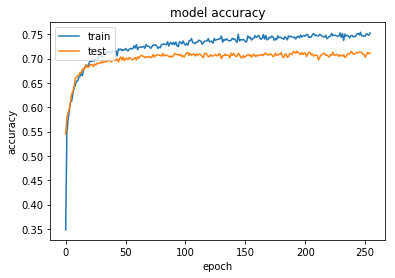

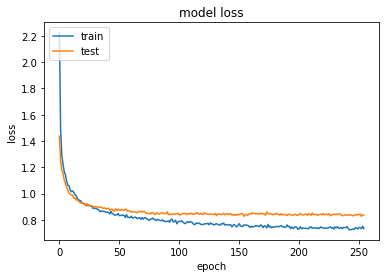

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
__________

In [13]:
# train model with 1st features dataset
train_model(model1_sc, X1_scaled_train, y1_scaled_train, 600, 50, 0.3, calls1)

# load saved best model
saved_model1 = load_model('./best_model1.h5')
print(saved_model1.summary())

The first model shows that the final accuracy is about 75%. However, the validation/testing data graph does not follow the training graph very well after the first few epochs. This probably means that the model is overfitting. To prevent overfitting there are a couple of algorithm tuning steps I could take including some of the following:
- Initialize class weights
- Change the activation function
- Change the number of batches and/or epochs
- Batch normalization between layers
- Change early stopping parameters

I first started with just using a single hidden layer and some standard defaults for the optimizer ('adam') and the activation function ('relu'). To improve the accuracy of the model, I added two more layers. Above 3 hidden layers, there was indistinguishable improvement. Next, I added a dropout of 20% to each layer, followed by a batch normalization step. These two steps did not cause the accuracy to improve, but they did significantly reduce the overfitting that was happening as shown in the graphs of the testing and training accuracy and losses. I followed up by changing the optimizer ('adadelta', 'adamax', 'rmsprop'). None of these changes made a significant difference in the model loss or accuracy so I stayed with the standard default of 'adam'. Finally, I tried different activation functions ('tanh', 'PReLU', LeakyReLU'). Again, none of this made a drastic improvement in the model, so I continued with the standard 'relu' function. 

In regards to loss and accuracy, the second model performed worse in all scenarios. It also suffered from similar overfitting issues. From here forward, the primary focus will be on using the first feature set to complete the predictions on the test set.

The next step in the process is to evaluate the robustness of the model through K-folds.

### K-folds

One way to test the accuracy of the model is to use K-fold cross validation. This splits the training dataset into k different sets/folds. The model is then trained on k-1 of the datasets and tests on the one set that is left out. To preserve the class distribution in each set, stratified k-folds are often used for classification problems. Once all of the folds have been trained on, then the final accuracy of the model is the average of the k different models. This [tutorial]( https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/) gives some beginner code on how to implement K-fold validation for a neural network.

In [14]:
X1_array = X1_scaled_train.to_numpy() # k-folds requires array input instead of pandas dataframe/series
y1_array = y1_target_list.to_numpy()

Running fold 1 / 5


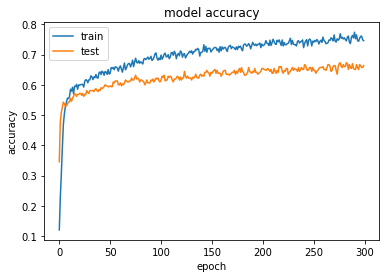

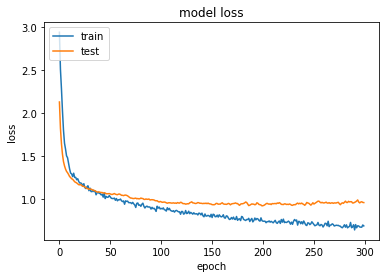

acc: 77.95%
Running fold 2 / 5


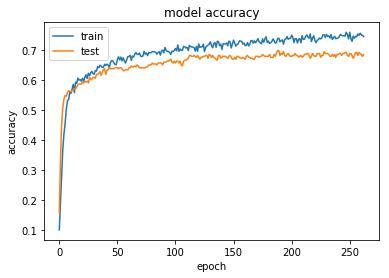

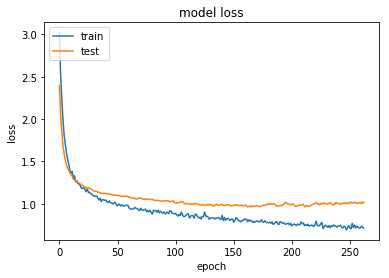

acc: 77.23%
Running fold 3 / 5


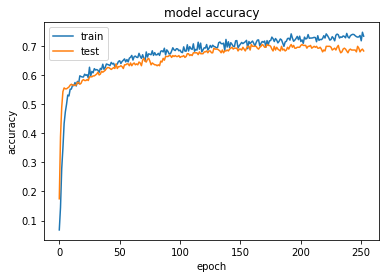

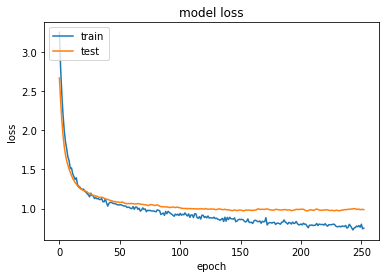

acc: 76.38%
Running fold 4 / 5


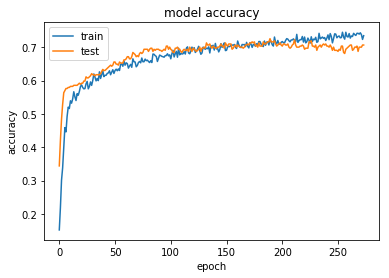

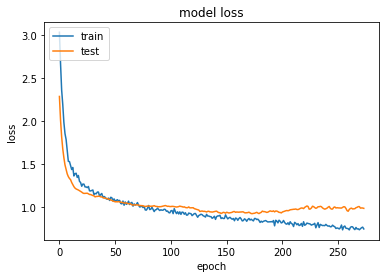

acc: 76.64%
Running fold 5 / 5


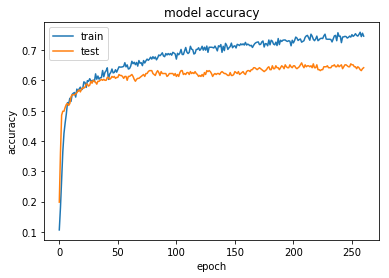

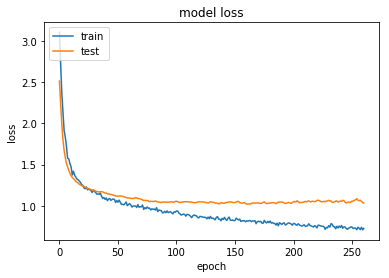

acc: 75.58%
76.76% (+/- 0.80%)


In [15]:
nfolds = 5
kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
cvscores = []

for i, (train, test) in enumerate(kfold.split(X1_array, y1_array)):
    # need 1d array for target variable in the split call:
    # https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
    
    print("Running fold {} / {}".format(i + 1, nfolds)) 
    filepath = "fold " + str(i+1) + " bestmodel.hdf5" # i+1 b/c indexing starts at 0
    mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    # set callbacks
    call = [esm, mc]
    
    # create model     
    n_cols = X1_array.shape[1]
    n_classes = len(class_names)
    dropout_rate = 0.2    
    neurons = int((2/3)*n_cols + n_classes)
    
    model = Sequential()
    
    model.add(Dense(neurons, activation='relu', input_shape=(n_cols,))) # input layer
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, activation='relu')) # hidden layers (x3)...
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))   
    
    model.add(Dense(n_classes, activation='softmax')) # output layer
                    
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(X1_array[test], y1_scaled_train[test], validation_split=0.2, 
                       epochs=600, batch_size=100, verbose=0, callbacks=call)
    
    # plot model results
    plot_hist(result)
    
    # evaluate the model
    scores = model.evaluate(X1_array[test], y1_scaled_train[test], verbose=0) # need ohc target variable here    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

The above k-fold cross-validation shows that running the model multiple times has an average of 77.72% with a standard deviation of 0.93%. Therefore, the model is fairly robust and accurate is classifying objects correctly in the range of 76% - 79%. From the above graphs, it looks like the fourth model had one of the better accuracy percentages and the least amount of overfitting. Therefore, I will choose that as my base model to make predictions with. Since all of the models are based on the same architecture though, it would be sufficient to choose any of them as the weight parameters would be fairly close to one another.

In [16]:
mod1 = load_model('./fold 1 bestmodel.hdf5')
print(mod1.evaluate(X1_array, y1_scaled_train, verbose=0)) # show the accuracy of the model on the entire training set

[0.8559554867545156, 0.7140672782874617]


### Accuracy per class

Next, find the probability given by the model that each of the testing data belongs to a certain class. The output is an array of values per class, where most of them are very close to zero and one of the classes is close to 1. The closer that a each object's single class value is to 1, the more accurate the model is as is shown in the confusion matrices that follow.

In [17]:
preds_classes = mod1.predict_classes(X1_scaled_train)
preds_probs = mod1.predict_proba(X1_scaled_train)

In [18]:
# code from this example: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd' # print 2 decimals if normalize, else print integer value
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [19]:
# Get confusion matrix
cm = confusion_matrix(preds_classes, np.argmax(y1_scaled_train, axis=-1)) # ohc data needs to be converted back to a target list
np.set_printoptions(precision=2)

Normalized confusion matrix


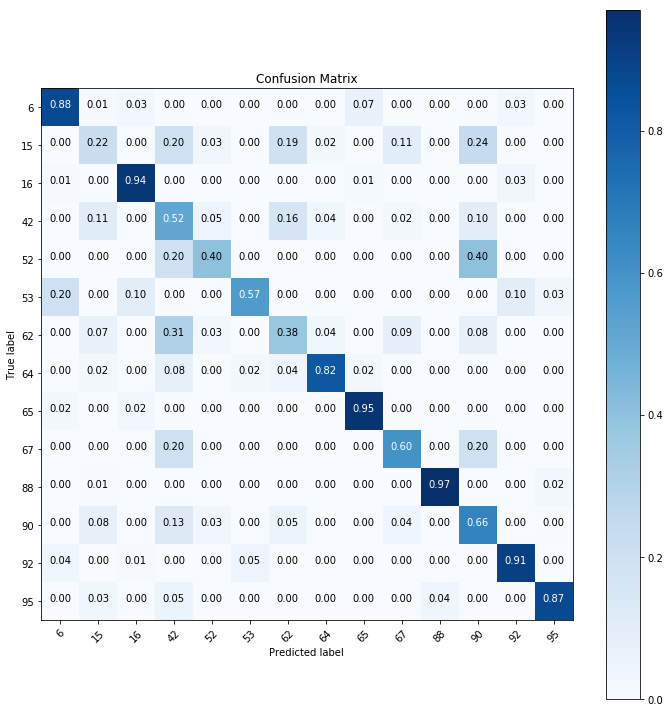

In [20]:
plt.figure(figsize=(10,10))
cm_plot = plot_confusion_matrix(cm, classes=class_names, normalize=True)

From the above confusion matrix is shows that classes 16, 65 and 88 are the most accurately predicted. On the other hand classes 15, 62 and 67 the model does a very bad job at predicting. There are two rows that have nan values. Targets 52 and 53 were never predicted by the model on the training set.

Instead of just looking at the accuracy of class predictions, we can also look at the precision, recall and f1-scores.

In [21]:
# code from this example:
# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report/31689645#31689645

def plot_classification_report(cr, title, cmap=plt.cm.Blues):

    lines = cr.split('\n')
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:        
        t = line.split()       
        #classes.append(t[0])
        v = [float(x) for x in t[1: len(t)-1]]
        plotMat.append(v)

    plt.figure(figsize=(10,10))
    
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=90)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

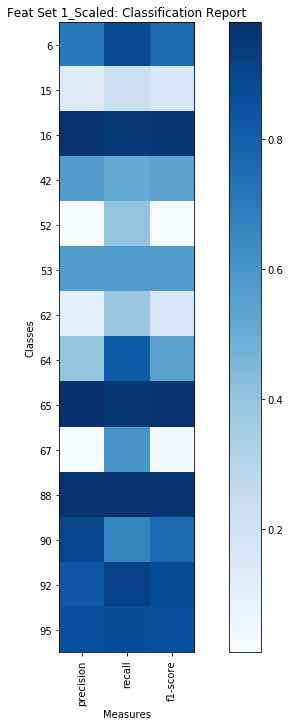

In [22]:
class_rpt = classification_report(preds_classes, np.argmax(y1_scaled_train, axis=-1))
plot_classification_report(class_rpt, 'Feat Set 1_Scaled: Classification Report')

The classificaion report shows similar results to the confusion matrix. Classes 16 and 88 are much easier to predict than the others. For class 15 it looks like the model is predicting a number of false positives because it has a low precision score (true pos / (true pos + false pos)).

## Make Test Set Predictions

Due to the large file size of the test set (file containing the flux information) it must be read and processed in chunks based on memory constraints of my computer. As each chunk is read, features are created, the data is modeled and predictions are appended to csv file. The next four cells of code follow heavily from [Siddhartha's Kaggle kernel](https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification).

In [23]:
# read in meta-data for test set
test_meta = pd.read_csv(data_folder / 'plasticc_data/test_set_metadata.csv') 

# remove features that were determined to not be useful in previous analysis
test_meta.drop(columns = ['ra', 'decl', 'gal_l', 'gal_b'], inplace = True) 

In [24]:
def standardize_values(df_train, df_test):
    
    # ignore by message about converting to float64
    warnings.filterwarnings("ignore", message="Data with input dtype")
    
    # fill NaNs with mean of columns from training set
    train_mean = df_train.mean(axis=0)
    df_train.fillna(train_mean, inplace=True)
    
    # fit the standard scalar to the training values
    ss = StandardScaler()
    df_train_ss = ss.fit(df_train)
    
    # use the standard scalar fit to transform the test values
    df_test[df_train.columns] = df_test[df_train.columns].fillna(train_mean)
    df_test_ss = ss.transform(df_test[df_train.columns])

    return df_test

In [45]:
start = time.time()
chunk_size = 500000

for chunk_i, df in enumerate(pd.read_csv(data_folder / 'plasticc_data/test_set.csv', 
                                         chunksize=chunk_size, 
                                         iterator=True)):
    
    det_grp = df[df['detected'] == 1]
    det_grp_mjd = det_grp.groupby('object_id')['mjd']
    df['mjd_diff'] = det_grp_mjd.transform('max') - det_grp_mjd.transform('min') 
    
    df['flux_ratio_sq'] = np.power(df.flux / df.flux_err, 2.0) 
    df['flux_weight'] = df.flux * df.flux_ratio_sq 
    df['flux_weight_sum'] = df.groupby('object_id').flux_ratio_sq.transform('sum') 
    df['flux_rsq_sum'] = df.groupby('object_id').flux_weight.transform('sum') 
    df['flux_w_mean'] = df.flux_weight_sum / df.flux_rsq_sum 
    df['flux_median'] = df.groupby('object_id').flux.transform('median') 
    df['MAD'] = np.abs(df.flux - df.flux_median) / df.flux_w_mean 
    df['flux_diff'] = np.abs(df.flux - df.flux_w_mean) 

    # aggregate features
    aggs = {
        'object_id': ['count'],
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean','std'],
        'flux_ratio_sq': ['sum','skew'],
        'flux_weight': ['sum','skew'],
        'mjd_diff': ['mean'],
        'MAD': ['median'],
        'flux_diff': ['mean']
    }

    df_agg = df.groupby('object_id').agg(aggs)

    # create column names for new aggregate features
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    df_agg.columns = new_columns

    # additional computed features
    df_agg['flux_weighted_mean'] = df_agg['flux_weight_sum'] / df_agg['flux_ratio_sq_sum']
    df_agg['flux_amp'] = df_agg['flux_max'] - df_agg['flux_min']
    df_agg['flux_norm_amp_mean'] = (df_agg['flux_max'] - df_agg['flux_min']) / df_agg['flux_mean']
    df_agg['flux_norm_amp_w_mean'] = (df_agg['flux_max'] - df_agg['flux_min']) / df_agg['flux_weighted_mean']
    df_agg['beyond_1std'] = sum(df_agg['flux_diff_mean'] > df_agg['flux_std']) / df_agg['object_id_count']

    # delete unused objects
    del df_agg['object_id_count'], df_agg['flux_diff_mean']
    del df
    gc.collect()
    
    # merge with meta data
    full_df = test_meta.merge(df_agg, on='object_id')
    
    # transform fluxes based on redshift
    columns_to_divide = ['flux_min', 'flux_max', 
                        'flux_mean', 'flux_median', 
                        'flux_ratio_sq_sum', 'flux_weighted_mean', 
                        'flux_amp']
    new_column_names = ['flux_min_wz', 'flux_max_wz', 
                        'flux_mean_wz', 'flux_median_wz', 
                        'flux_ratio_sq_sum_wz', 'flux_weighted_mean_wz', 
                        'flux_amp_wz']
    new_df = full_df[columns_to_divide].div(full_df['hostgal_photoz'] + 1, axis=0) 
    new_df.columns = new_column_names       
    full_df = full_df.merge(new_df, left_index=True, right_index=True) 
    
    # standardize values and impute NaNs if applicable
    full_df_ss = standardize_values(full_df, X1_train)
    
    # make predictions
    probs = mod1.predict_proba(full_df_ss)
    class_preds = mod1.predict_classes(full_df_ss)

    # store predictions / class probabilities
    df_probs = pd.DataFrame(probs, columns=class_names)
    df_probs['object_id'] = full_df['object_id'] 
    df_preds = pd.DataFrame(class_preds)
    df_preds['object_id'] = full_df['object_id'] 
    
    if chunk_i == 0:
        df_probs.to_csv('predictions.csv',  header=True) # add headers if file doesn't previously exist
        df_preds.to_csv('final_predictions.csv',  header=True)
    else: 
        df_probs.to_csv('predictions.csv',  header=False, mode='a') # append data to file
        df_preds.to_csv('final_predictions.csv',  header=False, mode='a')
        
    # delete data prior to next run through loop
    del df_agg, full_df, full_df_ss, df_probs, probs

    # after every 10 chunks, print progress of chunk reading 
    # print time (minutes) elapsed for number of lines in test_set file  
    if (chunk_i + 1) % 10 == 0: # add 1 because python indices start at 0
        print('%15d done in %5.1f min' % (chunk_size * (chunk_i + 1), (time.time() - start) / 60))

        5000000 done in   1.0 min
       10000000 done in   2.1 min
       15000000 done in   3.5 min
       20000000 done in   5.0 min
       25000000 done in   6.5 min
       30000000 done in   8.0 min
       35000000 done in   9.5 min
       40000000 done in  11.0 min
       45000000 done in  12.5 min
       50000000 done in  14.0 min
       55000000 done in  15.4 min
       60000000 done in  16.9 min
       65000000 done in  18.3 min
       70000000 done in  19.8 min
       75000000 done in  21.3 min
       80000000 done in  22.7 min
       85000000 done in  24.2 min
       90000000 done in  25.6 min
       95000000 done in  27.0 min
      100000000 done in  28.5 min
      105000000 done in  30.0 min
      110000000 done in  31.4 min
      115000000 done in  32.8 min
      120000000 done in  34.4 min
      125000000 done in  35.8 min
      130000000 done in  37.2 min
      135000000 done in  38.6 min
      140000000 done in  40.0 min
      145000000 done in  41.4 min
      15000000

### Format Prediction File

As the chunks are read through the above code, there is not a check to see if a chunk breaks up data in the middle of a single observation of an object. Therefore, we have to check if there are duplicate entries for an object_id. From the challenge information, it is known that there is only one observation per object_id in the test set.

The requirements of the challenge are to submit a .csv file with each object_id in a new row with the class names as column names. The cells should be the probability that the object is a certain class.

In [46]:
z = pd.read_csv(data_folder /'predictions.csv')

print(z.groupby('object_id').size().max()) # maximum number of times an object_id is duplicated
print((z.groupby('object_id').size() > 1).sum()) # number objects that are duplicated

z = z.groupby('object_id').mean() # get the mean prediction/probability of the duplicated object_ids

z.drop(columns=['Unnamed: 0'], inplace=True)

z['99'] = 0 # I didn't add in weights for an 'unknown' object

z.rename(index=str, columns={'6': 'class_6', '15': 'class_15', '16': 'class_16', '42': 'class_42',
                             '52': 'class_52', '53': 'class_53', '62': 'class_62', '64': 'class_64', 
                             '65': 'class_65', '67': 'class_67', '88': 'class_88', '90': 'class_90', 
                             '92': 'class_92', '95': 'class_95', '99': 'class_99'}, inplace=True)

z.to_csv('single_predictions.csv') # save new file with one prediction per object_id

2
901


Using the chunks method to read the test set resulted in 901 values that were duplicated, but none more than twice.

## Visualize Prediction Results

In [47]:
final_preds = pd.read_csv(data_folder /'single_predictions.csv')
final_preds['object_id'] = final_preds['object_id'].astype(np.int32)
final_preds.to_csv(data_folder /'final_predictions.csv', index=False)

### Barplot of Target Counts

I read in final csv file to generate visualizations of my results. I had to do a little bit more processing of this file to get it into a format that could be plotted. Also, the challenge creators wanted people to predict a class (class_99) that was not trainable (i.e. one that didn't show up in the training dataset). This was so that they could be able to discover new astronomical objects if possible through the algorithm. I decided not to do this part of the challenge due to time constraints so I just created class_99 with all zeroes.

In [48]:
final_preds.drop(columns=['object_id', 'class_99'], inplace=True)
# due to time constraints I didn't actually predict class_99, 
# but it was needed for the final submission to the challenge
# so I filled the row with zeroes for the time being

In [49]:
final_dist = final_preds.round(0).sum(axis=0) # round to nearest int and then sum over each column
orig_list = ['orange', 'blue', 'orange', 'blue', 
             'blue', 'orange', 'blue', 'blue', 
             'orange', 'blue', 'blue', 'blue', 
             'orange', 'blue'] # set color values for galactic/extra- classes (to match EDA graph)

Look to see if the overall distribution of the test set predictions match those that were given in the training data (graph shown in the EDA portion of this project).

In [50]:
final_df = pd.DataFrame({'Sum_Predictions': final_dist, 'Origin': orig_list})

final_df['Class_Probability'] = final_df['Sum_Predictions'] / (final_df['Sum_Predictions'].sum())

with errstate(divide='ignore'):
    final_df['Log_Class'] = np.log(final_df['Sum_Predictions'])

final_df['Log_Class'][isneginf(final_df['Log_Class'])]=0 

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


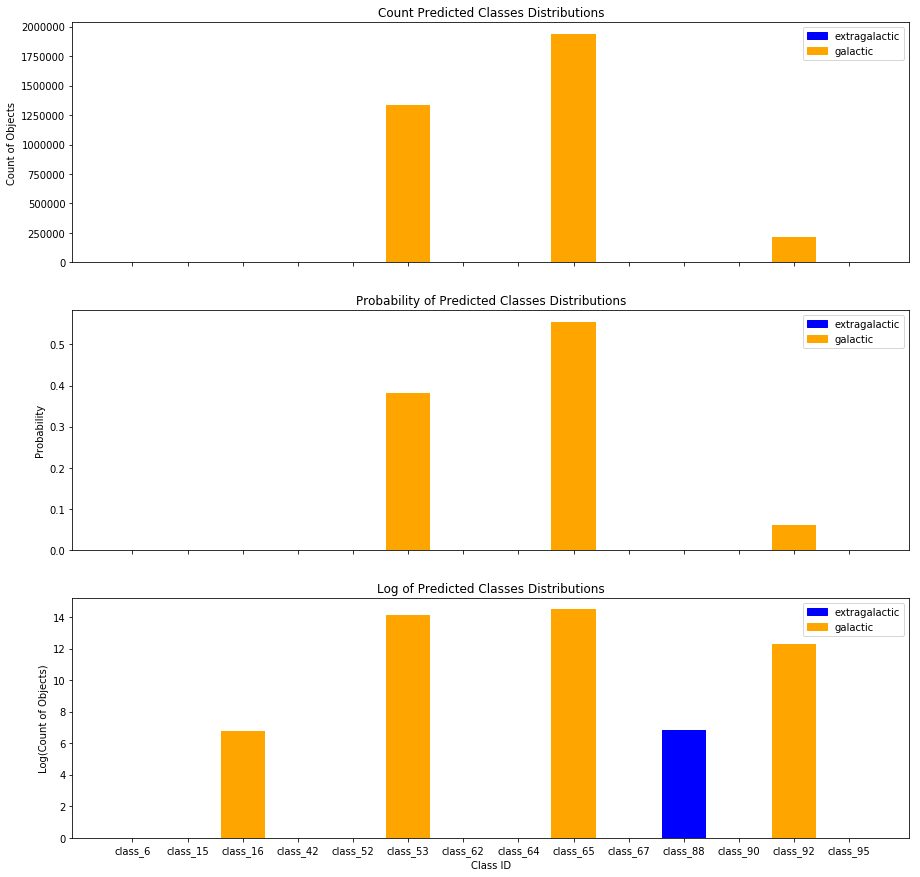

In [51]:
# visualize the above grouping
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,15), sharex=True)

blue = mpatches.Patch(color='blue', label='extragalactic')
orange = mpatches.Patch(color='orange', label='galactic')

ax1.bar(final_df.index, final_df.Sum_Predictions, color=final_df['Origin'])
ax1.set_title('Count Predicted Classes Distributions')
ax1.set_ylabel('Count of Objects')
ax1.legend(handles=[blue, orange], loc=1)

ax2.bar(final_df.index, final_df.Class_Probability, color=final_df['Origin'])
ax2.set_title('Probability of Predicted Classes Distributions')
ax2.set_ylabel('Probability')
ax2.legend(handles=[blue, orange], loc=1)

ax3.bar(final_df.index, final_df.Log_Class, color=final_df['Origin'])
ax3.set_title('Log of Predicted Classes Distributions')
ax3.set_ylabel('Log(Count of Objects)')
ax3.set_xlabel('Class ID')
ax3.legend(handles=[blue, orange], loc=1)

plt.show()

I first generated a graph of the total counts of each of the targets that were predicted. I only saw three bars, but they had up to 2 million instances and I thought some of the other targets just could not be visualized on the current graph. Therefore, I took the log of the counts so that all of the predicted targets would show up on a single graph. However, I still realized that my model did not perform very well on the test set and there were a total of 5 classes that my model would predict while there were actually 15 different types of targets.

### Confusion Matrix

Next, I looked at the accuracies for how each target was predicted using a confusion matrix of the predicted values vs. the actual values.

In [52]:
p_classes = pd.read_csv(data_folder /'final_predictions.csv')
meta_w_labels = pd.read_csv(data_folder / 'plasticc_data/plasticc_test_metadata.csv')
actual_targets = meta_w_labels['true_target']

In [96]:
class_names_act = list(np.unique(actual_targets))

In [ ]:
p_classes.set_index('object_id', inplace=True) # set object_id as index
pred_series = p_classes.idxmax(axis=1) # find column where row is maximized
pred_series = pred_series.apply(lambda x: x.replace(x[:6], '')) # remove 'class_' part of column name
pred_series = pd.to_numeric(pred_series) # convert string column name to target integer

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Normalized confusion matrix


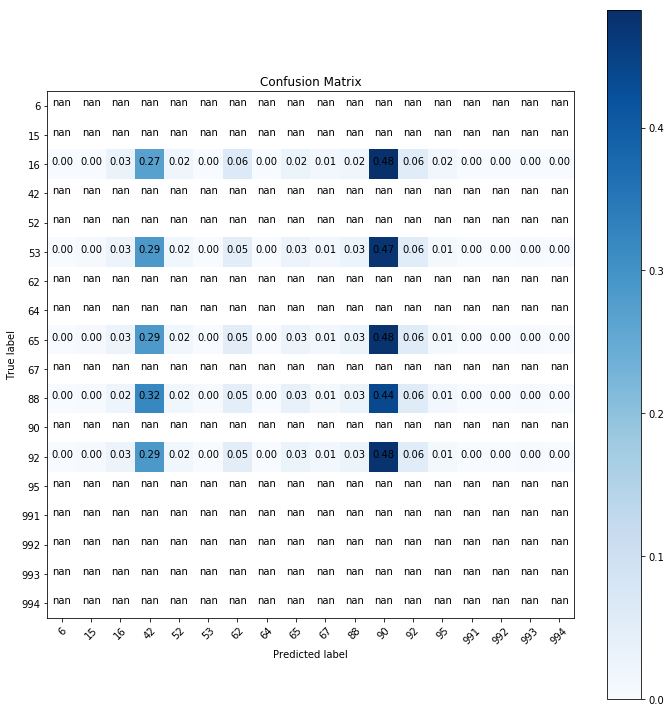

In [97]:
test_cm = confusion_matrix(pred_series, actual_targets)
np.set_printoptions(precision=2)

plt.figure(figsize=(10,10))
test_cm_plot = plot_confusion_matrix(test_cm, classes=class_names_act, normalize=True)

The above heatmap of the confusion matrix shows again, that my model only was successful at predicting 5 of the 14 labels and even for those labels it did not do a great job at getting them accurately.

### Final Multi Log Loss Metric

My final submission to the Kaggle challenge website got me a multi-loss log-likelihood score of 32.60645.

## Future Work

Although, during the model building and optimizing process I came up with a decent accuracy of 78%, this did not translate well to the testing set. There are a number of thins I would immediately try to improve my results.

1. Use more advanced methods of feature generation.
    - Use different libraries such as Cesium package.
    - Fit light curves with a gaussian (or similar) function and derive features based on FWHM, rise/fall times, etc.
    - Use passbands and ratios between them to understand light signatures better. I completely ignored these the first time through.
    - Use the Lomb-Scargle method to find period of time-variance use a phase transformation.
2. Determine how testing set compares to training set and investigate biases between the two.
    - I had assumed that the training set was a descriptive sample of the test set.  Towards the end of my project I found one discussion post comparing the two sets and there seemed to be a bias with some of the variables in the test set. The discussion started had used the test set bias to alter the training set which greatly enhanced his model's predictive capabilities.
3. Break up data based on galactic vs. extragalactic origin and model sets individually.
    - With a smaller sample set and since targets did not overlap it might be easier to make predictions.